In [1]:
from CGCNN_MT.module.module_utils import plot_scatter, plot_roc_curve, plot_confusion_matrix
from sklearn import metrics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
log_dir = Path("./CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43")
fig_dir = Path("./CGCNN_MT/evaluation/figures")

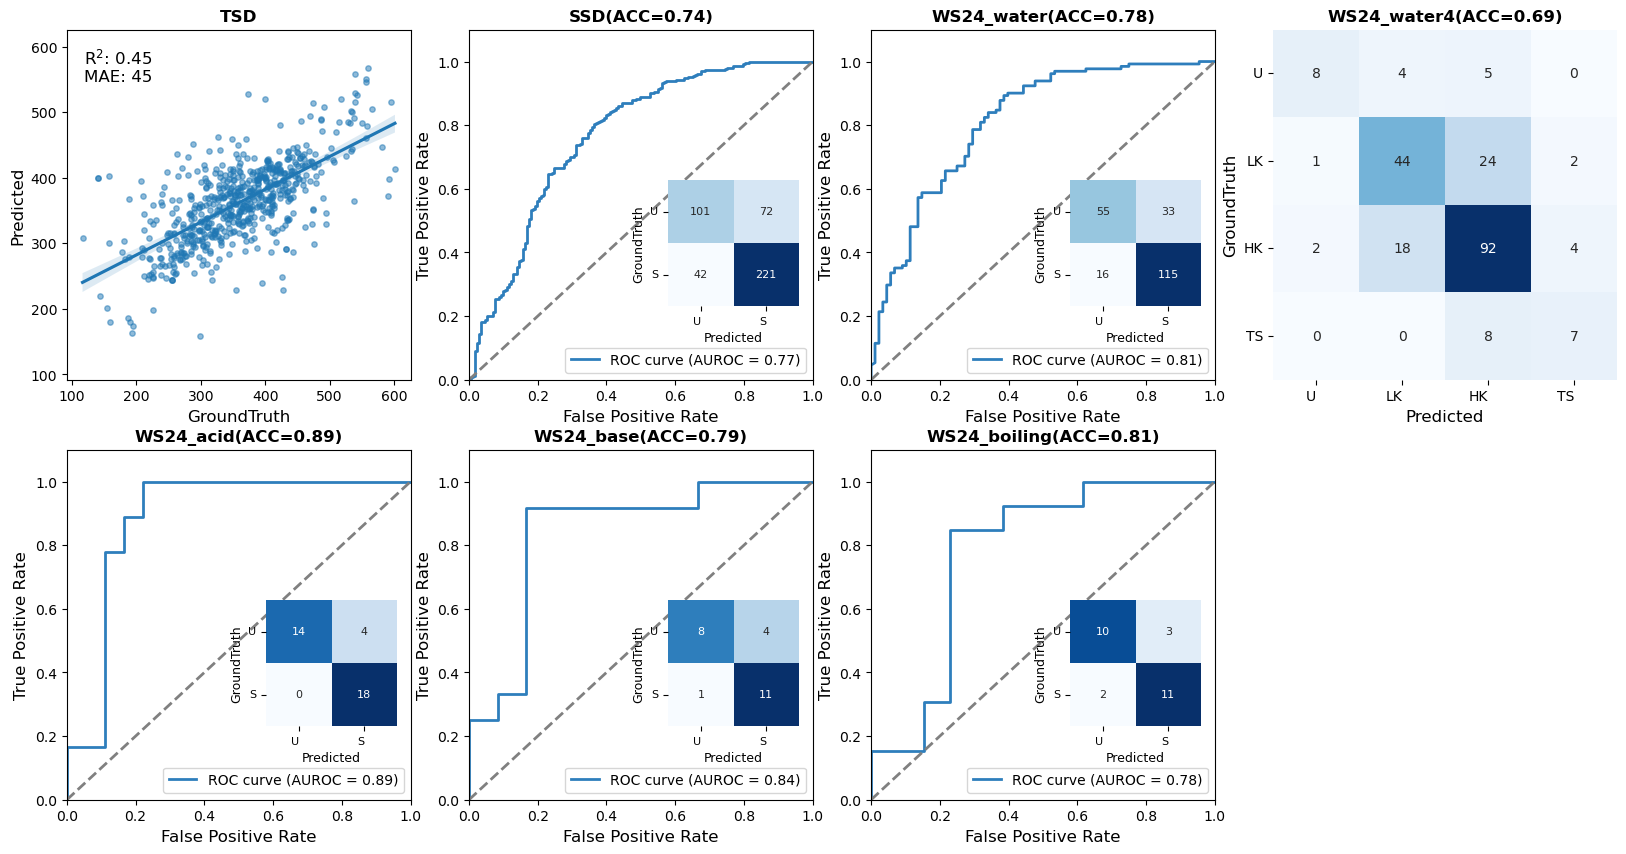

In [13]:
tasks = ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]
fig = plt.figure(figsize=(20, 10))
nrows = 2
ncols = 4
gs = gridspec.GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1], wspace=0.17, hspace=0.2)
for i, task in enumerate(tasks):
    row = i // (ncols)
    col = i % (ncols)
    ax = plt.subplot(gs[row, col])
    res_file = log_dir / f"test_results_{task}.csv"
    df = pd.read_csv(res_file)
    if "Prob" not in df.columns:
        r2 = metrics.r2_score(df["GroundTruth"], df["Predicted"])
        mae = metrics.mean_absolute_error(df["GroundTruth"], df["Predicted"])
        sns.regplot(data=df, x="GroundTruth", y="Predicted", ax=ax, scatter_kws={"alpha": 0.5, "s": 15})
        ax.text(0.05, 0.95, f"R$^2$: {r2:.2f}\nMAE: {mae:.0f}", transform=ax.transAxes, fontsize=12, verticalalignment='top')
        min_val = df[["GroundTruth", "Predicted"]].min().min()
        max_val = df[["GroundTruth", "Predicted"]].max().max()
        range_val = max_val - min_val
        ax.set_xlim(min_val-range_val*0.05, max_val+range_val*0.05)
        ax.set_ylim(min_val-range_val*0.05, max_val+range_val*0.05)
        ax.set_xlabel("GroundTruth", fontdict={"size": 12})
        ax.set_ylabel("Predicted", fontdict={"size": 12})
        ax.set_title(task, weight='bold')
    else:
        y_pred = df["Predicted"].values
        y_true = df["GroundTruth"].values
        y_prob = df["Prob"].values
        y_prob = np.array([eval(x) if isinstance(x, str) else x for x in y_prob])
    
        # 计算混淆矩阵
        cm = metrics.confusion_matrix(y_true, y_pred)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        roc_auc = metrics.roc_auc_score(y_true, y_prob, multi_class="ovo")
        if len(y_prob.shape) == 1:
            # 计算ROC曲线
            fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
            # 绘制ROC曲线
            ax.plot(fpr, tpr, color='#2e7ebc', lw=2, label='ROC curve (AUROC = %0.2f)' % roc_auc)
            ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.1])
            ax.set_xlabel('False Positive Rate', fontdict={"size": 12})
            ax.set_ylabel('True Positive Rate', fontdict={"size": 12})
            ax.set_title(task)
            ax.legend(loc="lower right")

            # 在左下角嵌入混淆矩阵
            # 创建一个新的轴对象
            ax_inset = inset_axes(ax, width="40%", height="40%", loc='lower right', 
                      bbox_to_anchor=(0.01, 0.21, 0.95, 0.9), bbox_transform=ax.transAxes, borderpad=0)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_inset, annot_kws={"size": 8})
            ax_inset.set_xlabel('Predicted', fontdict={"size": 9})
            ax_inset.set_ylabel('GroundTruth', fontdict={"size": 9})
            ax_inset.set_xticklabels(["U", "S"], rotation=0, ha="right", fontdict={"size": 8})
            ax_inset.set_yticklabels(["U", "S"], rotation=0, ha="right", fontdict={"size": 8})
            # ax.text(0.05, 0.95, f"AUROC: {roc_auc:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment='top')
            
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
            ax.set_xlabel('Predicted', fontdict={"size": 12})
            ax.set_ylabel('GroundTruth', fontdict={"size": 12})
            # ax.set_title(f'Confusion Matrix\nAccuracy = {accuracy:.2f}')
            ax.set_xticklabels(["U", "LK", "HK", "TS"], rotation=0, ha="right")
            ax.set_yticklabels(["U", "LK", "HK", "TS"], rotation=0, ha="right")
            
        ax.set_title(f"{task}(ACC={accuracy:.2f})", weight='bold')
plt.savefig(fig_dir / "test_preds.tif", dpi=96, bbox_inches='tight')
plt.show()